## Setup

In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler,OrdinalEncoder
from sklearn.ensemble import random_forest_classifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import confusion_matrix, classification_report,multilabel_confusion_matrix,make_scorer, f1_score,ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score


## Loading the Data

In [228]:
def load_data(filepath):
    data = pd.read_csv(filepath, sep=r'\s+', skiprows=1, header=None)
    data.columns = [
    "modified Zurich class", "largest spot size", "spot distribution",
    "activity", "evolution", "previous 24 hour flare activity",
    "historically-complex", "became complex on this pass",
    "area", "area of largest spot", "common flares",
    "moderate flares", "severe flares"
    ]
    return data

def explore_data(data):
    print(data.head().T)
    print(data.describe())
    print(data.info())
    for col in flare_df.columns:
        if data[col].dtype == object:
            print(f"Value counts for column: {col}")
            print(flare_df[col].apply(lambda x: x if isinstance(x, str) else None).value_counts())

## Adding visualizations 

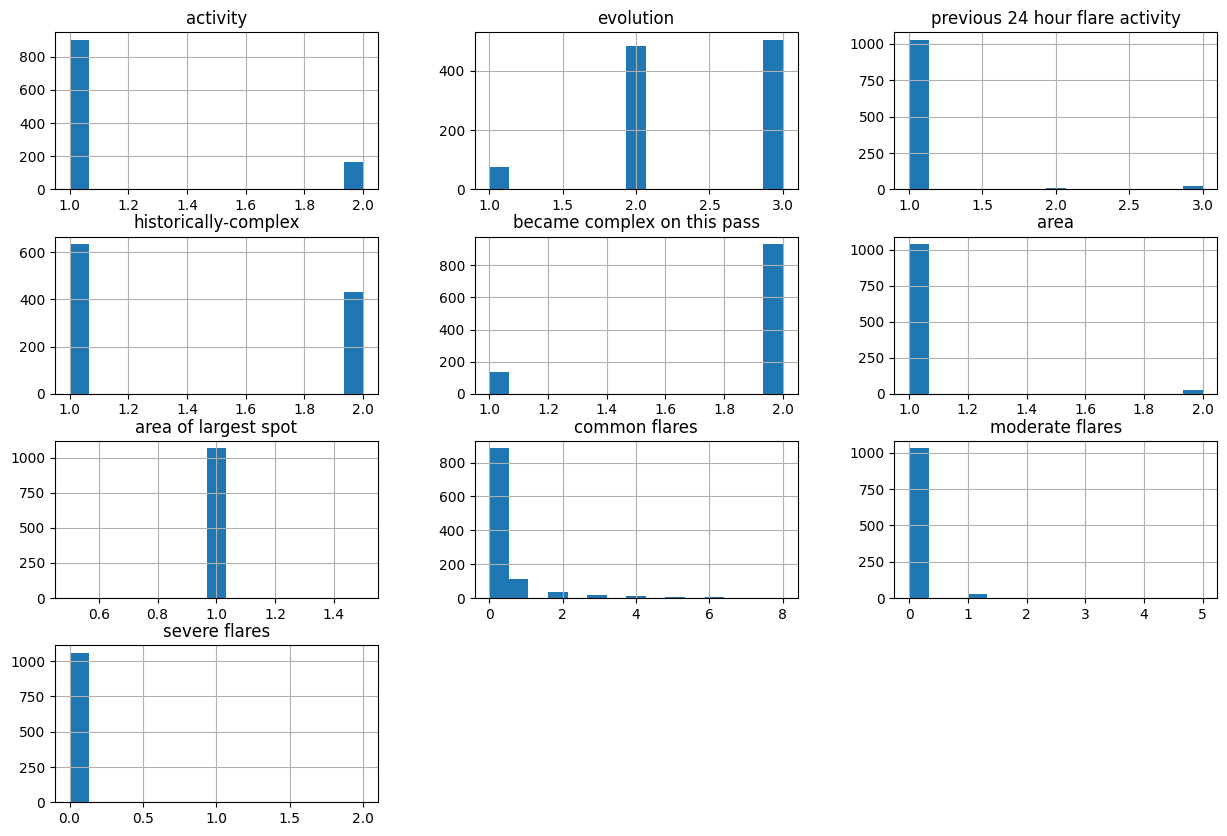

In [234]:
flare_df.hist(bins=15, figsize=(15,10))
plt.show()

In [235]:
columns_to_encode = ['modified Zurich class', 'largest spot size', 'spot distribution']
df_viz = flare_df[columns_to_encode].copy()
df_viz[columns_to_encode] = OrdinalEncoder().fit_transform(flare_df[columns_to_encode])

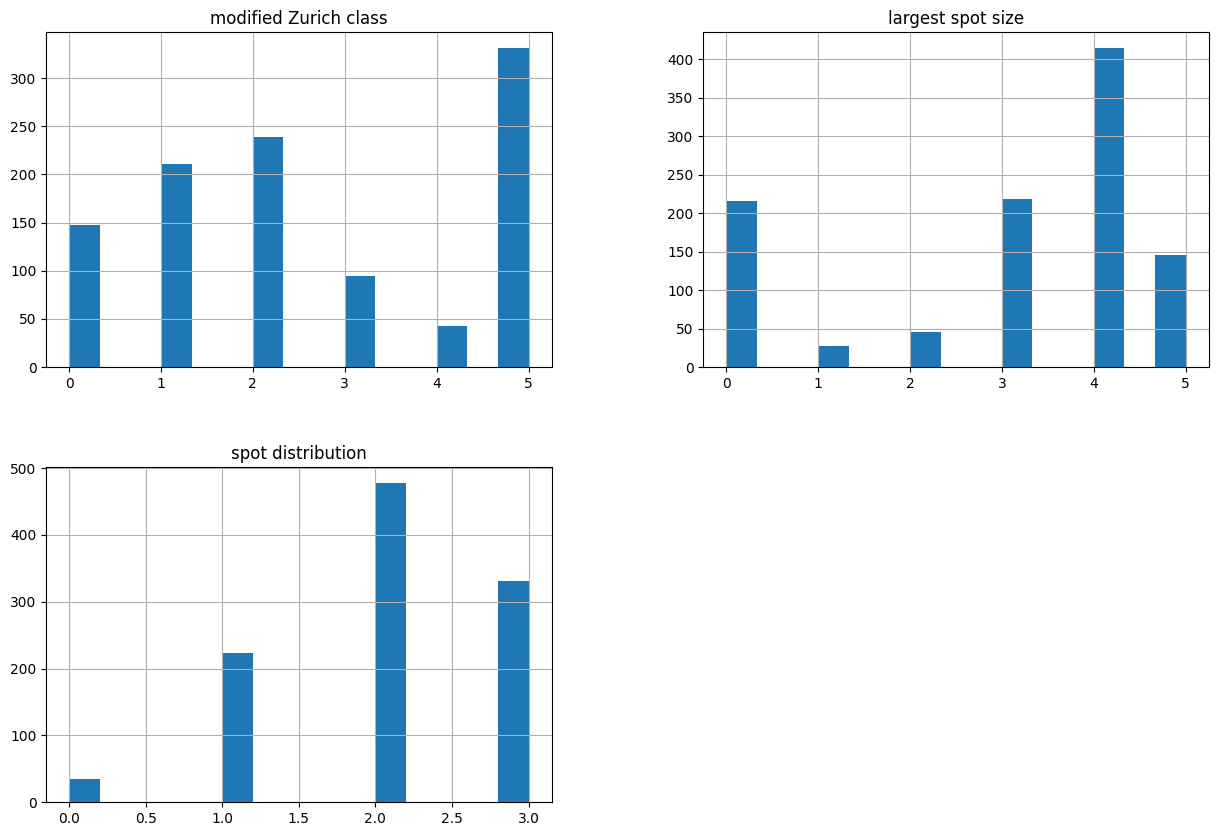

In [236]:
df_viz.hist(bins=15, figsize=(15,10))
plt.show()

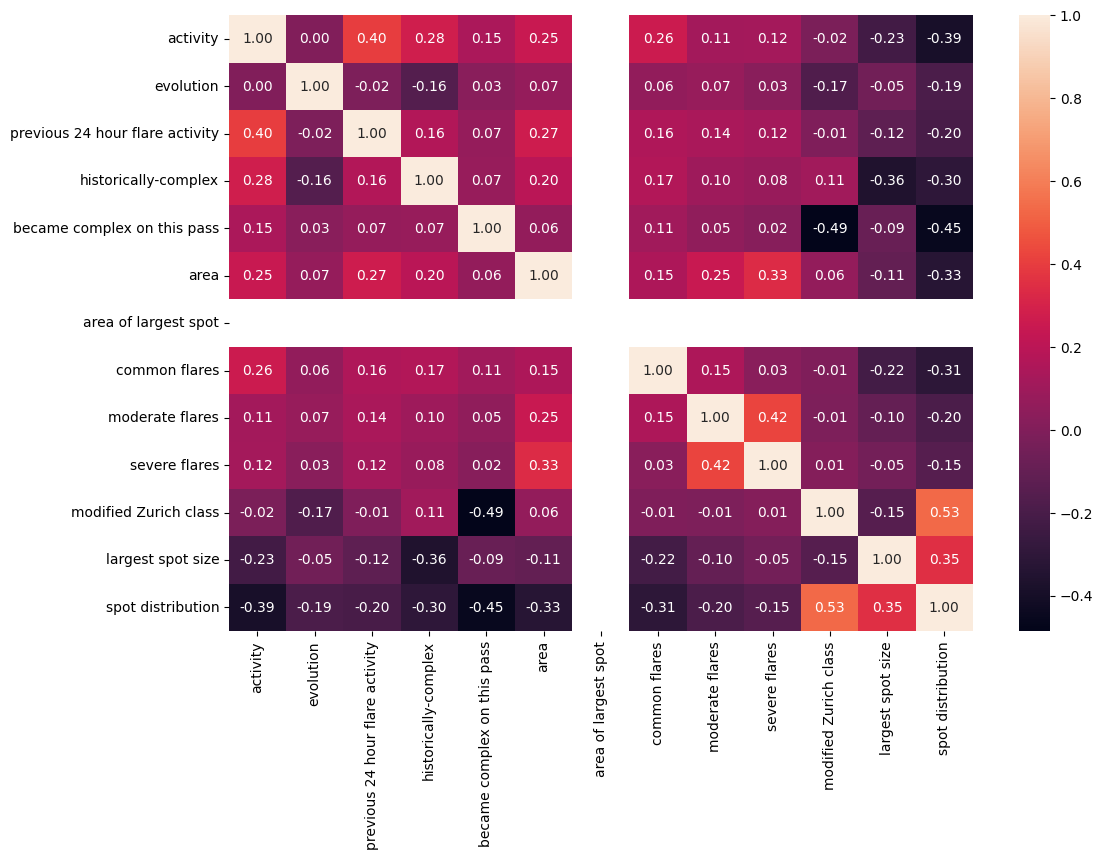

In [237]:
df_remaining = flare_df.drop(columns = columns_to_encode)
df_combined = pd.concat([df_remaining, df_viz], axis=1)
plt.figure(figsize=(12, 8))
sns.heatmap(df_combined.corr(), annot=True, fmt=".2f")
plt.show()

## Preprocessing and Feature Engineering

In [238]:
features_encoded = flare_df[columns_to_encode].copy()
ordinal_encoder = OrdinalEncoder()

features_encoded = pd.DataFrame(
    OrdinalEncoder().fit_transform(features_encoded), 
    index=features_encoded.index)
features_cat_ord = flare_df.drop(columns=columns_to_encode)
flare_df_encoded = pd.concat([features_cat_ord,features_encoded], axis=1)

In [239]:

target_columns = ['common flares', 'moderate flares', 'severe flares']

flare_df_encoded.columns = flare_df_encoded.columns.astype(str)
scaler = MinMaxScaler()
flare_df_scaled = pd.DataFrame(scaler.fit_transform(flare_df_encoded),
 index=flare_df_encoded.index, 
 columns=flare_df_encoded.columns)

flare_df['common flares'] = (flare_df['common flares'] > 0).astype(int) 
flare_df['moderate flares'] = (flare_df['moderate flares'] > 0).astype(int) 
flare_df['severe flares'] = (flare_df['severe flares'] > 0).astype(int)

## Splitting the Dataset

In [240]:
def split_data(data, target, test_size=0.2, random_state=42):
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)
    return X_train, X_test, y_train, y_test

X_train shape: (852, 10)
X_test shape: (214, 10)
y_train shape: (852, 3)
y_test shape: (214, 3)


## Training the Model

### Training random_forest_classifier Model

In [241]:
def train_random_forest_classifier_model(X_train, y_train):
    model_rf = random_forest_classifier(random_state=42)
    model_rf.fit(X_train, y_train)
    return model

RandomForestClassifier(random_state=42)

### Training LogisticRegression Model

In [242]:
def train_logistic_regression_model(X_train, y_train):
    # Create LogisticRegression models
    model_lr_common = LogisticRegression(max_iter=1000)
    model_lr_moderate = LogisticRegression(max_iter=1000)
    model_lr_severe = LogisticRegression(max_iter=1000)

    # Fit the models
    model_lr_common.fit(X_train, y_train['common flares'])
    model_lr_moderate.fit(X_train, y_train['moderate flares'])
    model_lr_severe.fit(X_train, y_train['severe flares'])

    # Return all trained models
    return model_lr_common, model_lr_moderate, model_lr_severe

LogisticRegression(max_iter=1000)

## Evaluating the Model

### Evaluating random_forest_classifier Model

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.35      0.36        34
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         0

   micro avg       0.35      0.32      0.33        38
   macro avg       0.12      0.12      0.12        38
weighted avg       0.33      0.32      0.32        38
 samples avg       0.06      0.05      0.05        38



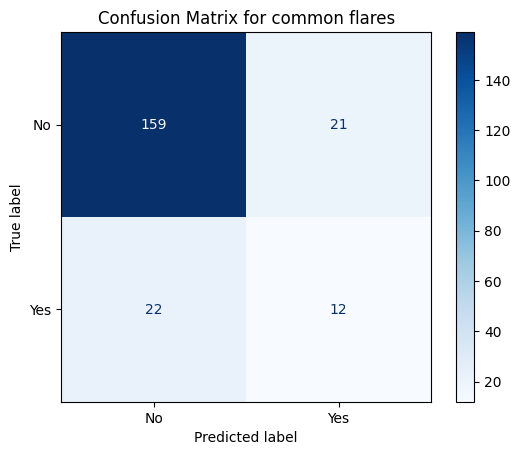

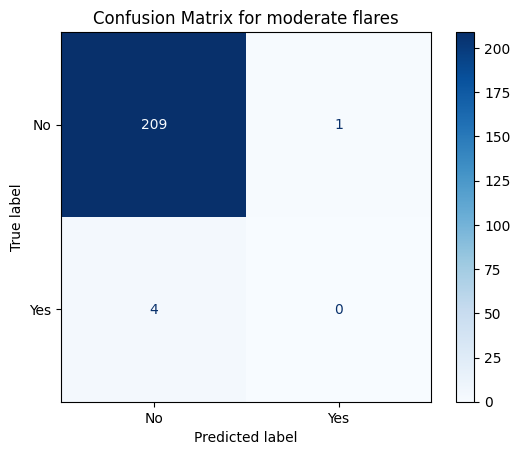

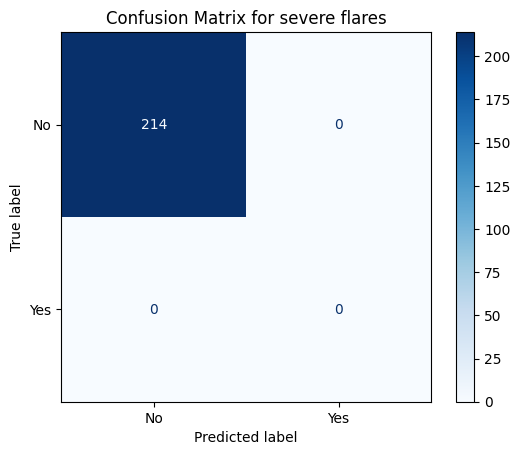

In [243]:
def evaluate_randomforestclasifier_model(model_rf, X_test, y_test):
    y_pred = model_rf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = multilabel_confusion_matrix(y_test, y_pred)

    for i in range(len(cm)):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm[i], display_labels=['No', 'Yes'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {y.columns[i]}')
        plt.show()

### Evaluating LogisticRegression Model

Classification Report for Common Flares:
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       180
           1       0.60      0.09      0.15        34

    accuracy                           0.85       214
   macro avg       0.73      0.54      0.53       214
weighted avg       0.81      0.85      0.79       214



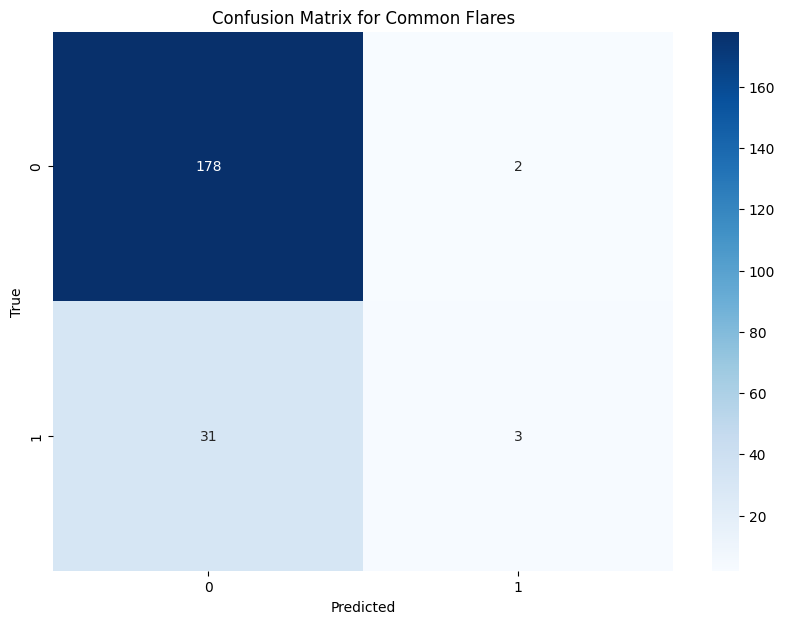

Classification Report for Moderate Flares:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       210
           1       0.00      0.00      0.00         4

    accuracy                           0.98       214
   macro avg       0.49      0.50      0.50       214
weighted avg       0.96      0.98      0.97       214



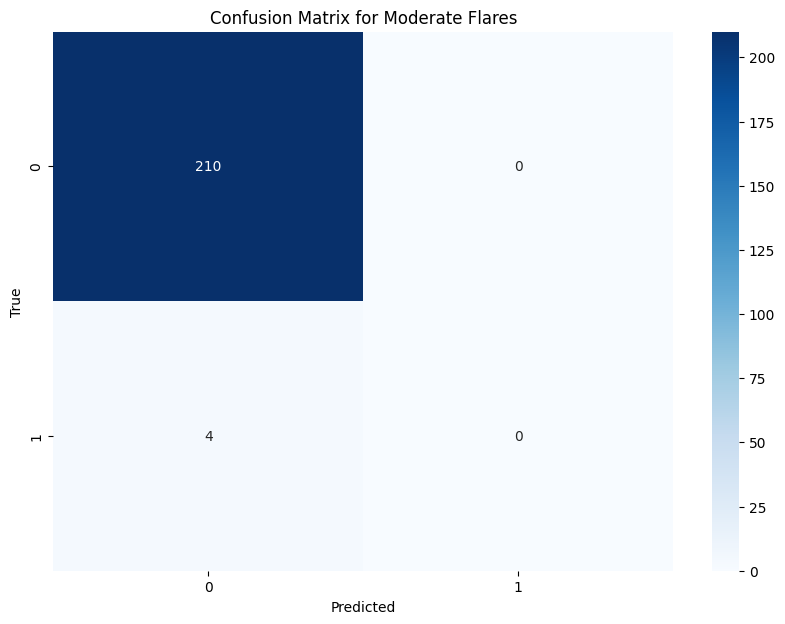

Classification Report for Severe Flares:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       214

    accuracy                           1.00       214
   macro avg       1.00      1.00      1.00       214
weighted avg       1.00      1.00      1.00       214



c:\Users\raria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


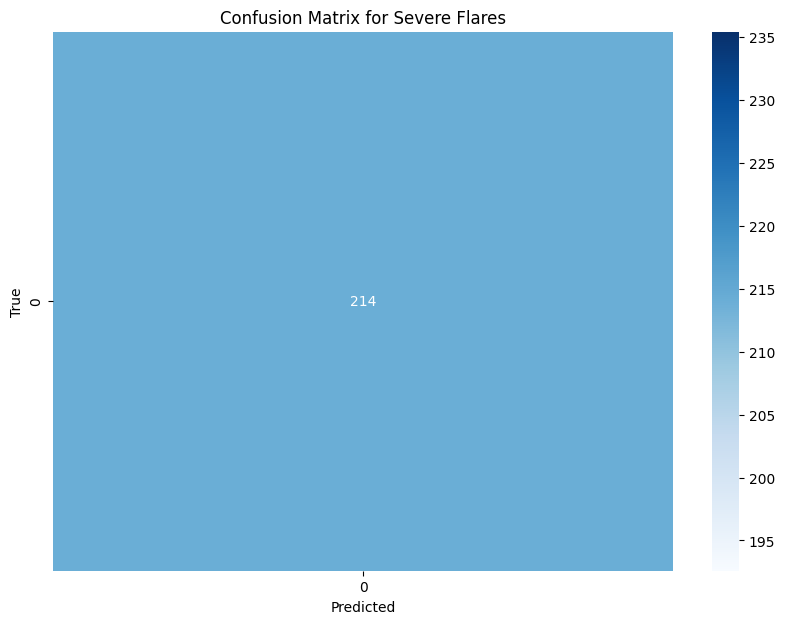

In [244]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

def evaluate_model(y_true, y_pred, title):
    print(f"Classification Report for {title}:")
    print(classification_report(y_true, y_pred, zero_division=0))
    plot_confusion_matrix(y_true, y_pred, f'Confusion Matrix for {title}')

def evaluate_logistic_regression_model(model_lr, X_test, y_test,flare_types):
    for flare_type, model in zip(flare_types, models):
        y_pred = model.predict(X_test)
        evaluate_model(y_test[flare_type], y_pred, flare_type.capitalize())

## Improving the Model

### Improving random_forest_classifier Model

In [245]:
def cross_validate_random_forest_classifier_model(model_lr, X, y,flare_type,cv=5):
    # Define the scoring method
    scoring = make_scorer(f1_score, average='macro', zero_division=0)

    for flare_type in flare_types:
        # Perform cross-validation
        scores = cross_val_score(model, X, y[flare_type], cv=cv, scoring=scoring)
        
        print(f"F1 scores for {flare_type.capitalize()}:", scores)
        print(f"Mean F1 score for {flare_type.capitalize()}:", scores.mean())


F1 scores for each fold: [0.07575758 0.13605442 0.11320755 0.12820513 0.13675214]
Mean F1 score: 0.11799536193067191


### Improving LogisticRegression Model

In [246]:
def cross_validate_logistic_regression_model(model_lr, X, y,flare_types):
    for model, flare_type in zip(models, flare_types):
        scores = cross_val_score(model, X, y[flare_type], cv=5)
        print(f"Cross-validation scores for {flare_type.capitalize()}:", scores)

Cross-validation scores for Common Flares: [0.8411215  0.84507042 0.82159624 0.82629108 0.8028169 ]
Cross-validation scores for Moderate Flares: [0.96261682 0.96713615 0.96713615 0.96713615 0.96713615]
Cross-validation scores for Severe Flares: [0.9953271  0.99530516 0.99530516 0.99530516 0.99530516]


## Implementing Main Function 

In [ ]:
# Main function for running the pipeline
def main(filepath):
    data = load_data(filepath)
    explore_data(data)
    #plot_histograms(data)
    #plot_correlation_matrix(data)
    #plot_feature_relationships(data, 'quality')
    
    #data_scaled = scale_features(data, 'quality')
    #X_train, X_test, y_train, y_test = split_data(data_scaled, 'quality')
    flare_types = ['common flares', 'moderate flares', 'severe flares']
    model_rf = train_random_forest_classifier_model(X_train, y_train)
    evaluate_randomforestclasifier_model(model_rf, X_test, y_test)
    cross_validate_random_forest_classifier_model(model_rf, X_train, y_train, flare_types)

    model_lr = train_logistic_regression_model(X_train, y_train)
    evaluate_logistic_regression_model(model_lr, X_test, y_test,flare_types)
    cross_validate_logistic_regression_model(model_rf, X_train, y_train,flare_types)

In [ ]:
main(filepath=r'../data/raw/flare.data2')